# Wstęp
Stworzone są nastepujące wykresy:
- Rozkład głównych emocji
- Rozkład podrzędnych emocji
- Rozkład par emocji (głowna, podrzędna)


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

con = sqlite3.connect("game_database.db")
cur = con.cursor()

c:\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [111]:

sql_query = '''SELECT * FROM PlayerEmotions pe
                LEFT JOIN difficulties d ON (pe.game_id = d.game_id) AND (pe.game_id NOT IN (SELECT d2.game_id FROM difficulties d2 GROUP BY d2.game_id HAVING COUNT(*) > 1));'''

df = pd.read_sql_query(sql_query, con)

# change values between columns player_z and face_confidence;
df['player_z'], df['face_confidence'] = df['face_confidence'], df['player_z']

# filter out the rows where the face_confidence is less than 0.9
df = df[df['face_confidence'] >= 0.9]
df.loc[df['second_emotion_value'] < 0.1, 'second_emotion'] = "none"
print(df.head())

   game_id first_emotion  first_emotion_value second_emotion  \
0       58       neutral            99.998924           none   
1       58       neutral            99.609207          happy   
2       58       neutral            99.156670          happy   
3       58       neutral            99.975517           none   
4       58       neutral            99.989166           none   

   second_emotion_value  player_z  face_confidence  game_id  difficulty_level  
0              0.000759       1.0       357.646729     58.0               2.0  
1              0.351305       1.0       770.153137     58.0               2.0  
2              0.825660       1.0      1182.530762     58.0               2.0  
3              0.021916       1.0      1585.970825     58.0               2.0  
4              0.009491       1.0      1993.787720     58.0               2.0  


# Plotting

## Rozkłady zmiennych

c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


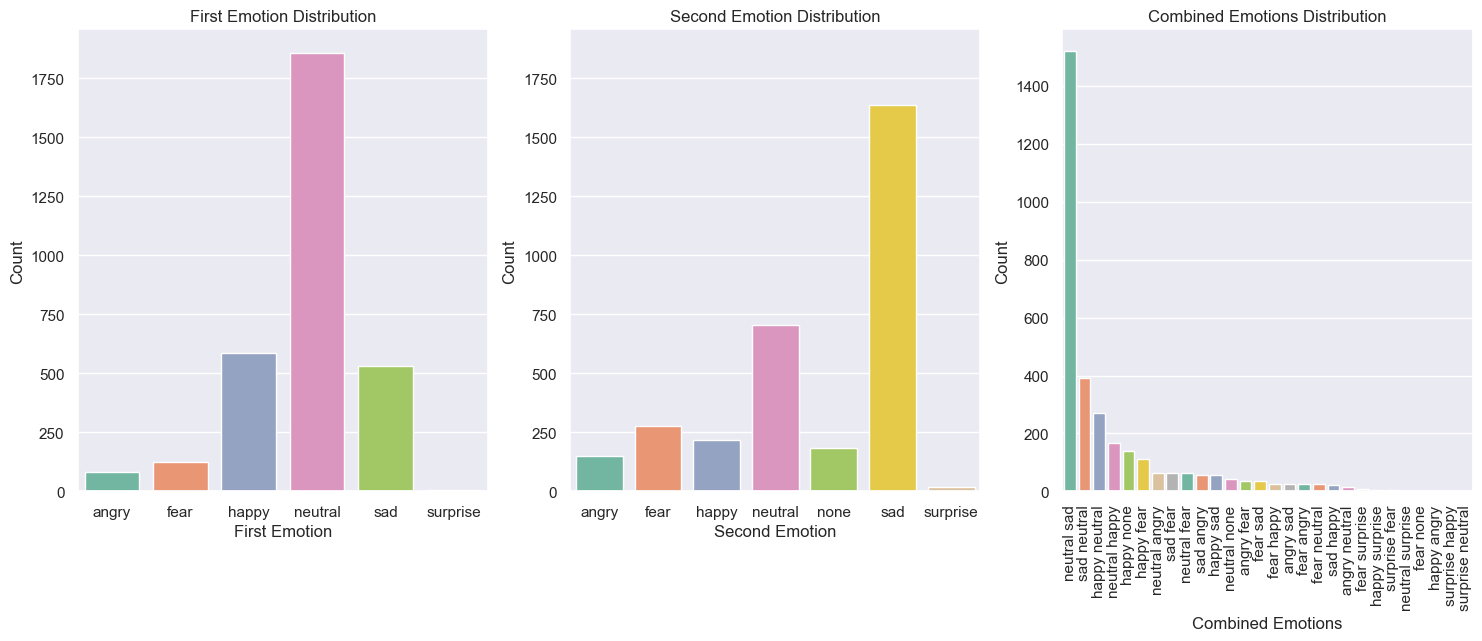

In [112]:
# Plot first_emotion and second_emotion distribution
df_plot = df.copy()
max_emotions_count = df_plot[['first_emotion', 'second_emotion']].apply(pd.Series.value_counts).max().max() + 100

# change emotions to categorical values
df_plot['combined_emotions'] = df_plot['first_emotion'] + ' ' + df_plot['second_emotion']

df_plot['first_emotion'] = df_plot['first_emotion'].astype('category')
df_plot['second_emotion'] = df_plot['second_emotion'].astype('category')

# Change second emotion to None if second_emotion_value is lower than 0.1


fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.countplot(x='first_emotion', data=df_plot, palette='Set2', ax=ax[0])
ax[0].set_title('First Emotion Distribution')
ax[0].set_xlabel('First Emotion')
ax[0].set_ylabel('Count')
ax[0].set_ylim(0, max_emotions_count)

sns.countplot(x='second_emotion', data=df_plot, palette='Set2', ax=ax[1])
ax[1].set_title('Second Emotion Distribution')
ax[1].set_xlabel('Second Emotion')
ax[1].set_ylabel('Count')
ax[1].set_ylim(0, max_emotions_count)

# plot the count plot of combined emotions
sns.countplot(x='combined_emotions', data=df_plot, palette='Set2', ax=ax[2], order=df_plot['combined_emotions'].value_counts().index)
ax[2].set_xlabel('Combined Emotions')
ax[2].set_ylabel('Count')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)
ax[2].set_title('Combined Emotions Distribution')

plt.show()

## Difficulty and Emotions

In [113]:
df_plot = df_plot.dropna(subset=['difficulty_level'])
print(df_plot[df_plot['difficulty_level'].isnull()])

Empty DataFrame
Columns: [game_id, first_emotion, first_emotion_value, second_emotion, second_emotion_value, player_z, face_confidence, game_id, difficulty_level, combined_emotions]
Index: []


c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


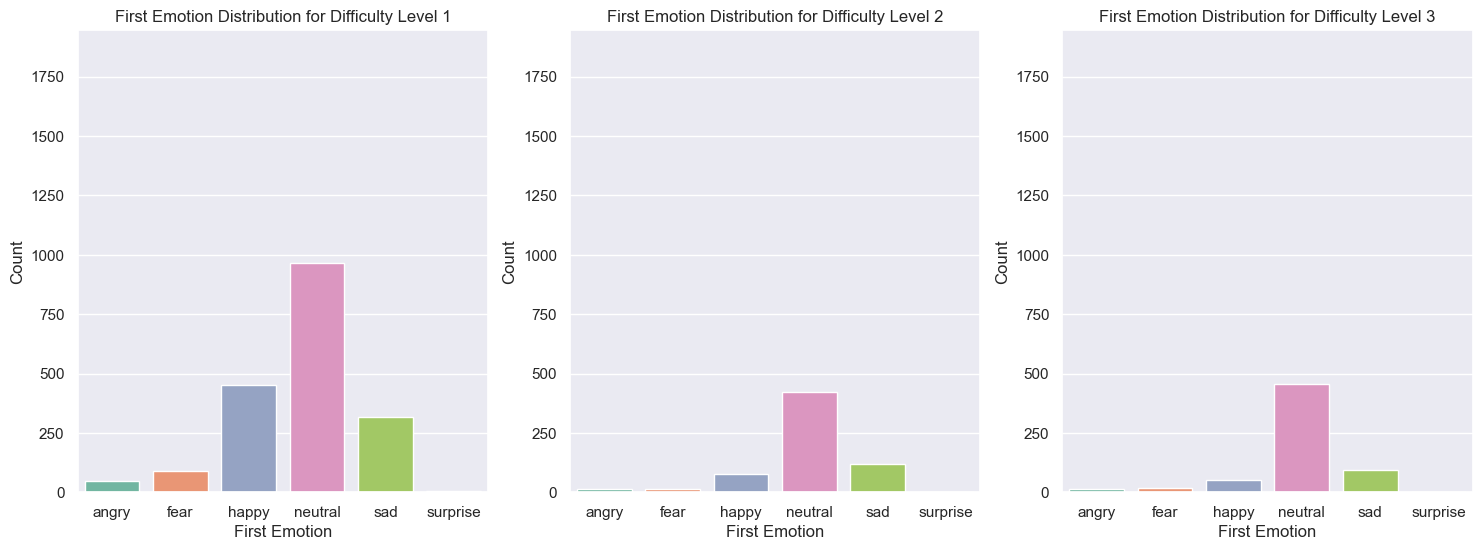

In [115]:
df_plot = df.copy()
df_plot = df_plot.dropna(subset=['difficulty_level'])
max_emotions_count = df_plot[['first_emotion', 'second_emotion']].apply(pd.Series.value_counts).max().max() + 100

# change emotions to categorical values
df_plot['combined_emotions'] = df_plot['first_emotion'] + ' ' + df_plot['second_emotion']

df_plot['first_emotion'] = df_plot['first_emotion'].astype('category')
df_plot['second_emotion'] = df_plot['second_emotion'].astype('category')

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for difficulty in df_plot['difficulty_level'].unique():
    i = int(difficulty) - 1
    df_plot_difficulty = df_plot[df_plot['difficulty_level'] == difficulty]
    sns.countplot(x='first_emotion', data=df_plot_difficulty, palette='Set2', ax=ax[i], label=difficulty)
    ax[i].set_title('First Emotion Distribution for Difficulty Level ' + str(i+1))
    ax[i].set_xlabel('First Emotion')
    ax[i].set_ylabel('Count')
    ax[i].set_ylim(0, max_emotions_count)


## Map and Emotions

In [3]:
sql_query = '''SELECT * FROM MapData md
JOIN Game g ON md.game_id = g.game_id
-- LEFT JOIN Obstacles o ON (o.position_z BETWEEN md.start AND md.end) AND (o.game_id = md.game_id)
LEFT JOIN difficulties d ON (md.game_id = d.game_id) AND (md.game_id NOT IN (SELECT d2.game_id FROM difficulties d2 GROUP BY d2.game_id HAVING COUNT(*) > 1))
LEFT JOIN PlayerEmotions pe ON (md.game_id = pe.game_id) AND (pe.player_z BETWEEN md.start AND md.end)
WHERE md.game_id NOT IN (SELECT d2.game_id FROM difficulties d2 GROUP BY d2.game_id HAVING COUNT(*) > 1)'''
df = pd.read_sql_query(sql_query, con)
df = df.drop(columns=['game_id'])

print(df.head())
print(df.columns)

           map_type  lane_change_prob  small_obs_prob  gate_prob  \
0  FirstObstacleMap               0.3             0.3       0.05   
1  FirstObstacleMap               0.3             0.3       0.05   
2  FirstObstacleMap               0.3             0.3       0.05   
3  FirstObstacleMap               0.3             0.3       0.05   
4  FirstObstacleMap               0.3             0.3       0.05   

             color_theme  start   end  generation_dist  score  \
0  COLOR_THEME_COLORFULL    500  2750              250   2699   
1  COLOR_THEME_COLORFULL    500  2750              250   2699   
2  COLOR_THEME_COLORFULL    500  2750              250   2699   
3  COLOR_THEME_COLORFULL    500  2750              250   2699   
4  COLOR_THEME_COLORFULL    500  2750              250   2699   

   player_satisfaction  playing_time  difficulty_level first_emotion  \
0                   -1      9.776133                 2       neutral   
1                   -1      9.776133                 2  

c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


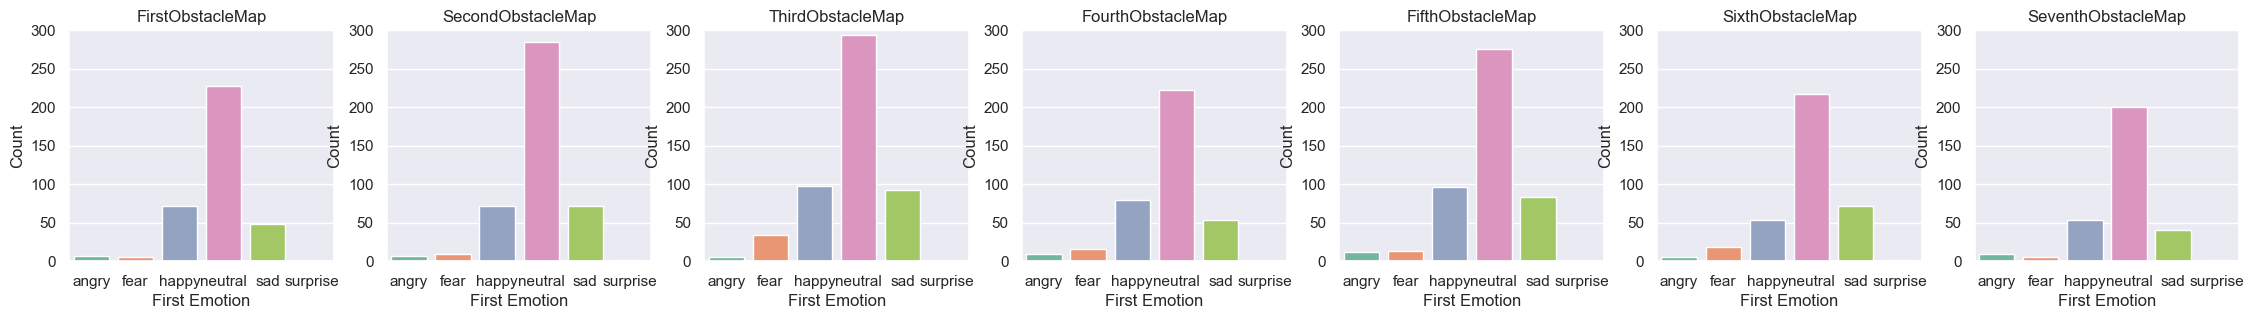

In [108]:
# create countplot for each emotion for each map_type
df_plot = df
df_plot['first_emotion'] = df_plot['first_emotion'].astype('category')
map_type = ['FirstObstacleMap', 'SecondObstacleMap', 'ThirdObstacleMap', 'FourthObstacleMap', 'FifthObstacleMap', 'SixthObstacleMap', 'SeventhObstacleMap']

fig, ax = plt.subplots(1,7, figsize=(28, 3))
for i, map_type in enumerate(map_type):
    df_map = df_plot[df_plot['map_type'] == map_type]
    sns.countplot(x='first_emotion', data=df_map, palette='Set2', ax=ax[i])
    ax[i].set_title(f'{map_type}')
    ax[i].set_xlabel('First Emotion')
    ax[i].set_ylabel('Count')
    ax[i].set_ylim(0, 300)

c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


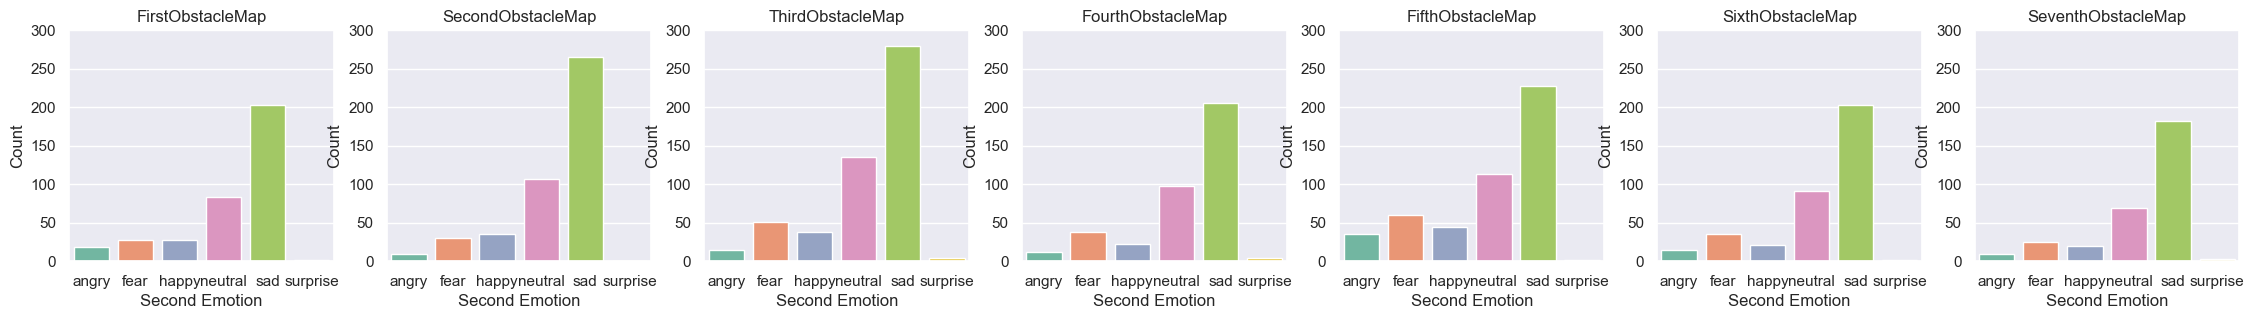

In [109]:
# create countplot for each emotion for each map_type
df_plot = df
df_plot['second_emotion'] = df_plot['second_emotion'].astype('category')
map_type = ['FirstObstacleMap', 'SecondObstacleMap', 'ThirdObstacleMap', 'FourthObstacleMap', 'FifthObstacleMap', 'SixthObstacleMap', 'SeventhObstacleMap']

fig, ax = plt.subplots(1,7, figsize=(28, 3))
for i, map_type in enumerate(map_type):
    df_map = df_plot[df_plot['map_type'] == map_type]
    sns.countplot(x='second_emotion', data=df_map, palette='Set2', ax=ax[i])
    ax[i].set_title(f'{map_type}')
    ax[i].set_xlabel('Second Emotion')
    ax[i].set_ylabel('Count')
    ax[i].set_ylim(0, 300)

## Satisfaction vs emotions

c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


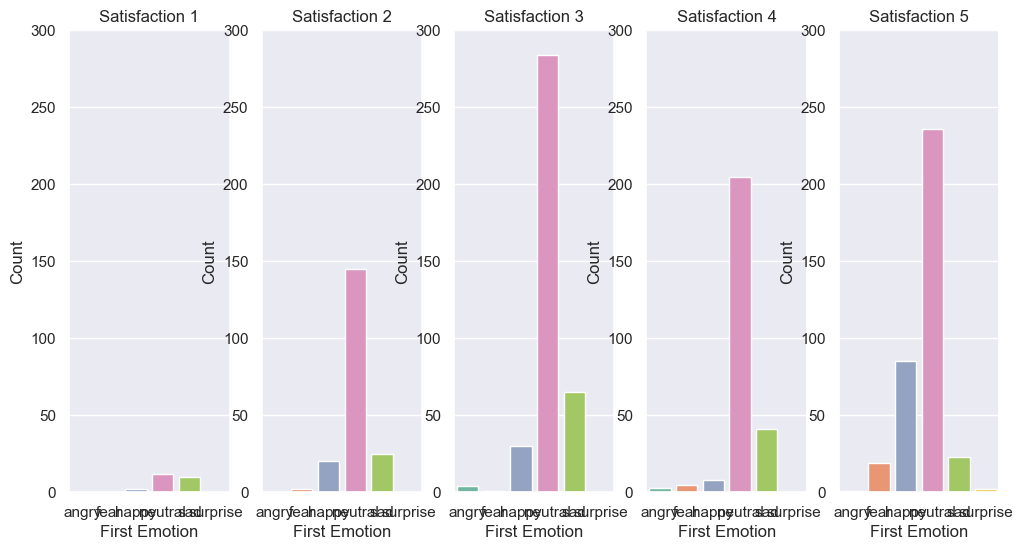

In [23]:
df_plot = df.copy()

# filter out games with time > 120 sec
df_plot = df_plot[df_plot['playing_time'] <= 120]

# first emotion as categorical
df_plot['first_emotion'] = df_plot['first_emotion'].astype('category')

fig, ax = plt.subplots(1, 5, figsize=(12, 6))
for satisfaction in range(1, 6):
    i = satisfaction - 1
    df_plot_satisfaction = df_plot[df_plot['player_satisfaction'] == satisfaction]
    sns.countplot(x='first_emotion', data=df_plot_satisfaction, palette='Set2', ax=ax[i], label=satisfaction)
    ax[i].set_title('Satisfaction ' + str(satisfaction))
    ax[i].set_xlabel('First Emotion')
    ax[i].set_ylabel('Count')
    ax[i].set_ylim(0, 300)

c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


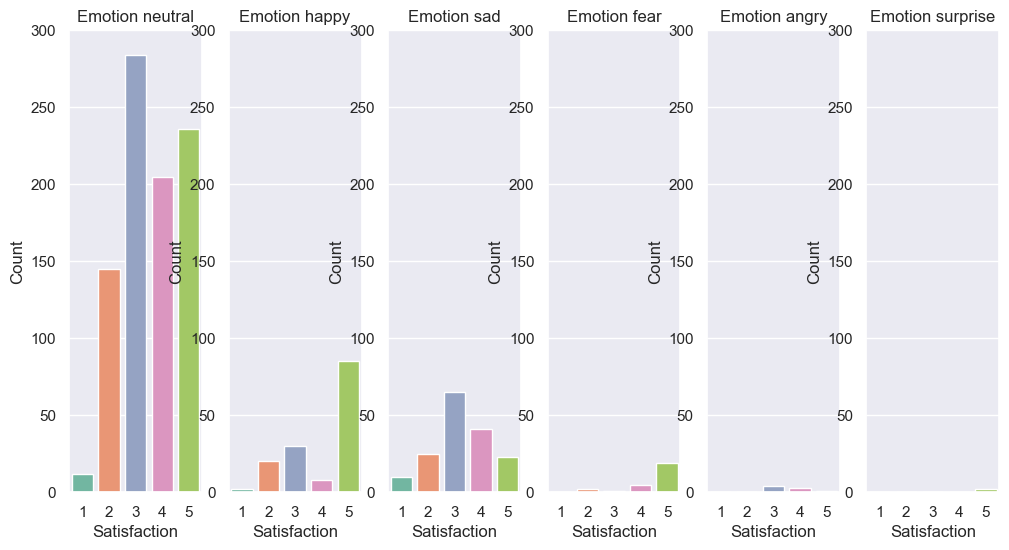

In [33]:
# plot satisfaction distribution for every emotion
df_plot = df.copy()
df_plot = df[df['playing_time'] <= 120]
df_plot = df_plot.dropna(subset=['first_emotion'])
# drop -1 values from player_satisfaction
df_plot = df_plot[df_plot['player_satisfaction'] != -1]
df_plot['first_emotion'] = df_plot['first_emotion'].astype('category')
df_plot['player_satisfaction'] = df_plot['player_satisfaction'].astype('category')

fig, ax = plt.subplots(1, 6, figsize=(12, 6))
for i, emotion in enumerate(df_plot['first_emotion'].unique()):
    df_plot_emotion = df_plot[df_plot['first_emotion'] == emotion]
    sns.countplot(x='player_satisfaction', data=df_plot_emotion, palette='Set2', ax=ax[i])
    ax[i].set_title('Emotion ' + str(emotion))
    ax[i].set_xlabel('Satisfaction')
    ax[i].set_ylabel('Count')
    ax[i].set_ylim(0, 300)